In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
class PetDataset(Dataset):
    def __init__(self, root="data/oxford-iiit-pet", is_train=True):
        if is_train:
            self.img_transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
            self.mask_transform = transforms.Compose([
                transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=15, interpolation=transforms.InterpolationMode.NEAREST),
                transforms.PILToTensor()
            ])
        else:
            self.img_transform  = transforms.Compose([
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])
            
            self.mask_transform = transforms.Compose([
                                transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
                                transforms.PILToTensor()
                            ])
        
        self.classes = ['background', 'pet', 'outline']
        self.root = root
        self.is_train = is_train
        
        if is_train:
            annotations = os.path.join(root, "annotations", "trainval.txt")
        else:
            annotations = os.path.join(root, "annotations", "test.txt")
        
        with open(annotations, 'r') as file:
            self.img_names = [image.split(' ')[0] for image in file.readlines()]
        
        torch.manual_seed(42)
        
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, item):
        img_name = self.img_names[item]
        img_path = os.path.join(self.root, "images", img_name) + ".jpg"
        mask_path = os.path.join(self.root, "annotations", "trimaps", img_name) + ".png"
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_fixed = np.zeros_like(mask)
        mask_fixed[mask == 2] = 0  # background
        mask_fixed[mask == 1] = 1  # pet
        mask_fixed[mask == 3] = 2  # outline
        
        mask = Image.fromarray(mask_fixed)
        
        if self.is_train:
            seed = torch.Generator().manual_seed(hash((img_name, item)) % 2**32)
            torch.manual_seed(seed.initial_seed())
            image = self.img_transform(image)
            torch.manual_seed(seed.initial_seed())
            mask = self.mask_transform(mask)
        else:
            image = self.img_transform(image)
            mask = self.mask_transform(mask)
        
        return image, mask

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 3, dropout = False):
        super(UNet, self).__init__()
        def conv_Block(in_channel, out_channel):
            layer =  nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True)
            )
            if dropout:
                layer.append(nn.Dropout2d(0.2))
            return layer
        
        self.enc1 = conv_Block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_Block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_Block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_Block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        self.bottle_neck = conv_Block(512, 1024)
        
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_Block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_Block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_Block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_Block(128, 64)
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
        # self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, img):
        e1 = self.enc1(img)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        
        b = self.bottle_neck(self.pool4(e4))
        
        d4 = self.up4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        
        return self.final(d1)

In [6]:
class FocalLoss(nn.Module): # to overcome huge background influence
    def __init__(self, alpha=1, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

class CombinedLoss(nn.Module):
    def __init__(self, weight=None):
        super(CombinedLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=1, gamma=2, weight=weight)
        self.ce_loss = nn.CrossEntropyLoss(weight=weight)
        
    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        ce = self.ce_loss(inputs, targets)
        return 0.7 * focal + 0.3 * ce

In [7]:
LEARNING_RATE = 1e-4
EPOCHS = 100
BATCH_SIZE = 8
WEIGHT_DECAY = 1e-4

train_dataset = PetDataset(is_train=True)
val_dataset = PetDataset(is_train=False)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True, drop_last=True, pin_memory=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False, drop_last=True, pin_memory=True)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet(in_channels=3, out_channels=3)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
class_weights = torch.tensor([1.0, 2.0, 3.0]).to(device)
criterion = CombinedLoss(weight=class_weights)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )

cuda


/users/pg24/manivannan/miniconda3/envs/newEnv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_progress= tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for images, masks in train_dataloader:
        images = images.to(device, non_blocking=True)
        masks = masks.squeeze(1).long().to(device, non_blocking=True)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, masks)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        train_progress.set_postfix(loss=loss.item())
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_dataloader:
            images = images.to(device, non_blocking=True)
            masks = masks.squeeze(1).long().to(device, non_blocking=True)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    scheduler.step(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }, 'best_unet_model.pth')
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")
    
    if optimizer.param_groups[0]['lr'] < 1e-7:
        print("Learning rate too small, stopping training")
        break

Epoch 1/100 [Train]:   0%|          | 0/460 [00:47<?, ?it/s, loss=0.498]

Epoch 1/100 - Train Loss: 0.6893, Val Loss: 0.5237
New best model saved with validation loss: 0.5237


Epoch 1/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.498]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 2/100 - Train Loss: 0.5122, Val Loss: 0.4665
New best model saved with validation loss: 0.4665


Epoch 3/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.426]

Epoch 3/100 - Train Loss: 0.4592, Val Loss: 0.4517
New best model saved with validation loss: 0.4517


Epoch 3/100 [Train]:   0%|          | 0/460 [01:02<?, ?it/s, loss=0.426]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 4/100 - Train Loss: 0.4283, Val Loss: 0.4222
New best model saved with validation loss: 0.4222


Epoch 5/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.37] 

Epoch 5/100 - Train Loss: 0.4073, Val Loss: 0.3871
New best model saved with validation loss: 0.3871


Epoch 5/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.37]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 6/100 - Train Loss: 0.3845, Val Loss: 0.3667
New best model saved with validation loss: 0.3667


Epoch 7/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.293]

Epoch 7/100 - Train Loss: 0.3718, Val Loss: 0.3868


Epoch 7/100 [Train]:   0%|          | 0/460 [01:00<?, ?it/s, loss=0.293]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 8/100 - Train Loss: 0.3539, Val Loss: 0.3705


Epoch 9/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.368]

Epoch 9/100 - Train Loss: 0.3419, Val Loss: 0.3453
New best model saved with validation loss: 0.3453


Epoch 9/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.368]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 10/100 - Train Loss: 0.3302, Val Loss: 0.3627


Epoch 11/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.408]

Epoch 11/100 - Train Loss: 0.3196, Val Loss: 0.3283
New best model saved with validation loss: 0.3283


Epoch 11/100 [Train]:   0%|          | 0/460 [01:02<?, ?it/s, loss=0.408]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 12/100 - Train Loss: 0.3047, Val Loss: 0.3318


Epoch 13/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.308]

Epoch 13/100 - Train Loss: 0.2963, Val Loss: 0.3475


Epoch 13/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.308]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 14/100 - Train Loss: 0.2899, Val Loss: 0.3197
New best model saved with validation loss: 0.3197


Epoch 15/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.474]

Epoch 15/100 - Train Loss: 0.2785, Val Loss: 0.3201


Epoch 15/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.474]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 16/100 - Train Loss: 0.2691, Val Loss: 0.3408


Epoch 17/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.265]

Epoch 17/100 - Train Loss: 0.2593, Val Loss: 0.3207


Epoch 17/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.265]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 18/100 - Train Loss: 0.2518, Val Loss: 0.3285


Epoch 19/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.204]

Epoch 19/100 - Train Loss: 0.2439, Val Loss: 0.3249


Epoch 19/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.204]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 20/100 - Train Loss: 0.2340, Val Loss: 0.3463


Epoch 21/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.173]

Epoch 21/100 - Train Loss: 0.2278, Val Loss: 0.3269


Epoch 21/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.173]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 22/100 - Train Loss: 0.2197, Val Loss: 0.3368


Epoch 23/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.195]

Epoch 23/100 - Train Loss: 0.2162, Val Loss: 0.3046
New best model saved with validation loss: 0.3046


Epoch 23/100 [Train]:   0%|          | 0/460 [01:02<?, ?it/s, loss=0.195]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 24/100 - Train Loss: 0.2075, Val Loss: 0.3286


Epoch 24/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.19]
Corrupt JPEG data: premature end of data segment
Epoch 25/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.215]

Epoch 25/100 - Train Loss: 0.2000, Val Loss: 0.3446


Epoch 25/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.215]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 26/100 - Train Loss: 0.1935, Val Loss: 0.3369


Epoch 27/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.211]

Epoch 27/100 - Train Loss: 0.1908, Val Loss: 0.3676


Epoch 27/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.211]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 28/100 - Train Loss: 0.1834, Val Loss: 0.4195


Epoch 29/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.196]

Epoch 29/100 - Train Loss: 0.1797, Val Loss: 0.4262


Epoch 29/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.196]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 30/100 - Train Loss: 0.1735, Val Loss: 0.3470


Epoch 31/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.145]

Epoch 31/100 - Train Loss: 0.1690, Val Loss: 0.3723


Epoch 31/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.145]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 32/100 - Train Loss: 0.1658, Val Loss: 0.3662


Epoch 33/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.182]

Epoch 33/100 - Train Loss: 0.1639, Val Loss: 0.3521


Epoch 33/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.182]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 34/100 - Train Loss: 0.1563, Val Loss: 0.3774


Epoch 35/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.12] 

Epoch 35/100 - Train Loss: 0.1331, Val Loss: 0.3752


Epoch 35/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.12]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 36/100 - Train Loss: 0.1257, Val Loss: 0.3879


Epoch 37/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.128] 

Epoch 37/100 - Train Loss: 0.1203, Val Loss: 0.4194


Epoch 37/100 [Train]:   0%|          | 0/460 [01:00<?, ?it/s, loss=0.128]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 38/100 - Train Loss: 0.1176, Val Loss: 0.4346


Epoch 39/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.107] 

Epoch 39/100 - Train Loss: 0.1148, Val Loss: 0.4593


Epoch 39/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.107]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 40/100 - Train Loss: 0.1129, Val Loss: 0.4627


Epoch 41/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.11]  

Epoch 41/100 - Train Loss: 0.1090, Val Loss: 0.4626


Epoch 41/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.11]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 42/100 - Train Loss: 0.1066, Val Loss: 0.4710


Epoch 43/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0971]

Epoch 43/100 - Train Loss: 0.1036, Val Loss: 0.4714


Epoch 43/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0971]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 44/100 - Train Loss: 0.1023, Val Loss: 0.4736


Epoch 45/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0873]

Epoch 45/100 - Train Loss: 0.0987, Val Loss: 0.4760


Epoch 45/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0873]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 46/100 - Train Loss: 0.0889, Val Loss: 0.4879


Epoch 47/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0843]

Epoch 47/100 - Train Loss: 0.0833, Val Loss: 0.5086


Epoch 47/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0843]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 48/100 - Train Loss: 0.0811, Val Loss: 0.5153


Epoch 49/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0771]

Epoch 49/100 - Train Loss: 0.0783, Val Loss: 0.5481


Epoch 49/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0771]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 50/100 - Train Loss: 0.0760, Val Loss: 0.5255


Epoch 51/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0704]

Epoch 51/100 - Train Loss: 0.0737, Val Loss: 0.5717


Epoch 51/100 [Train]:   0%|          | 0/460 [01:00<?, ?it/s, loss=0.0704]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 52/100 - Train Loss: 0.0718, Val Loss: 0.5773


Epoch 53/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0606]

Epoch 53/100 - Train Loss: 0.0699, Val Loss: 0.5600


Epoch 53/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0606]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 54/100 - Train Loss: 0.0674, Val Loss: 0.5733


Epoch 55/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0682]

Epoch 55/100 - Train Loss: 0.0661, Val Loss: 0.5722


Epoch 55/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0682]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 56/100 - Train Loss: 0.0643, Val Loss: 0.6142


Epoch 57/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.06]  

Epoch 57/100 - Train Loss: 0.0590, Val Loss: 0.6205


Epoch 57/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.06]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 58/100 - Train Loss: 0.0554, Val Loss: 0.6529


Epoch 59/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0485]

Epoch 59/100 - Train Loss: 0.0542, Val Loss: 0.6309


Epoch 59/100 [Train]:   0%|          | 0/460 [01:00<?, ?it/s, loss=0.0485]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 60/100 - Train Loss: 0.0530, Val Loss: 0.6502


Epoch 61/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0554]

Epoch 61/100 - Train Loss: 0.0517, Val Loss: 0.6442


Epoch 61/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0554]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 62/100 - Train Loss: 0.0506, Val Loss: 0.6431


Epoch 63/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0488]

Epoch 63/100 - Train Loss: 0.0494, Val Loss: 0.6962


Epoch 63/100 [Train]:   0%|          | 0/460 [01:00<?, ?it/s, loss=0.0488]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 64/100 - Train Loss: 0.0486, Val Loss: 0.6600


Epoch 65/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0506]

Epoch 65/100 - Train Loss: 0.0474, Val Loss: 0.6866


Epoch 65/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0506]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 66/100 - Train Loss: 0.0470, Val Loss: 0.6654


Epoch 67/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0475]

Epoch 67/100 - Train Loss: 0.0464, Val Loss: 0.6917


Epoch 67/100 [Train]:   0%|          | 0/460 [01:00<?, ?it/s, loss=0.0475]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 68/100 - Train Loss: 0.0437, Val Loss: 0.6900


Epoch 69/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0417]

Epoch 69/100 - Train Loss: 0.0420, Val Loss: 0.7189


Epoch 69/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0417]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 70/100 - Train Loss: 0.0413, Val Loss: 0.7200


Epoch 71/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.04]  

Epoch 71/100 - Train Loss: 0.0408, Val Loss: 0.7281


Epoch 71/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.04]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 72/100 - Train Loss: 0.0405, Val Loss: 0.7311


Epoch 73/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0411]

Epoch 73/100 - Train Loss: 0.0401, Val Loss: 0.7582


Epoch 73/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0411]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 74/100 - Train Loss: 0.0395, Val Loss: 0.7485


Epoch 75/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0349]

Epoch 75/100 - Train Loss: 0.0391, Val Loss: 0.7392


Epoch 75/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0349]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 76/100 - Train Loss: 0.0388, Val Loss: 0.7371


Epoch 77/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0375]

Epoch 77/100 - Train Loss: 0.0382, Val Loss: 0.7556


Epoch 77/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0375]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 78/100 - Train Loss: 0.0380, Val Loss: 0.7626


Epoch 79/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0399]

Epoch 79/100 - Train Loss: 0.0368, Val Loss: 0.7768


Epoch 79/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0399]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 80/100 - Train Loss: 0.0361, Val Loss: 0.7750


Epoch 81/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.035] 

Epoch 81/100 - Train Loss: 0.0359, Val Loss: 0.7624


Epoch 81/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.035]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 82/100 - Train Loss: 0.0354, Val Loss: 0.7757


Epoch 83/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0309]

Epoch 83/100 - Train Loss: 0.0353, Val Loss: 0.7774


Epoch 83/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0309]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 84/100 - Train Loss: 0.0350, Val Loss: 0.7954


Epoch 85/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0328]

Epoch 85/100 - Train Loss: 0.0349, Val Loss: 0.7783


Epoch 85/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0328]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 86/100 - Train Loss: 0.0348, Val Loss: 0.7912


Epoch 87/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0311]

Epoch 87/100 - Train Loss: 0.0343, Val Loss: 0.8080


Epoch 87/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0311]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 88/100 - Train Loss: 0.0341, Val Loss: 0.7984


Epoch 89/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0303]

Epoch 89/100 - Train Loss: 0.0340, Val Loss: 0.7867


Epoch 89/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0303]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 90/100 - Train Loss: 0.0335, Val Loss: 0.7956


Epoch 91/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0301]

Epoch 91/100 - Train Loss: 0.0332, Val Loss: 0.8196


Epoch 91/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0301]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 92/100 - Train Loss: 0.0331, Val Loss: 0.8229


Epoch 93/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0301]

Epoch 93/100 - Train Loss: 0.0331, Val Loss: 0.8233


Epoch 93/100 [Train]:   0%|          | 0/460 [01:00<?, ?it/s, loss=0.0301]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 94/100 - Train Loss: 0.0329, Val Loss: 0.8217


Epoch 95/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0329]

Epoch 95/100 - Train Loss: 0.0327, Val Loss: 0.8363


Epoch 95/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0329]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 96/100 - Train Loss: 0.0325, Val Loss: 0.8145


Epoch 97/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0305]

Epoch 97/100 - Train Loss: 0.0324, Val Loss: 0.8257


Epoch 97/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0305]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Epoch 98/100 - Train Loss: 0.0324, Val Loss: 0.8107


Epoch 99/100 [Train]:   0%|          | 0/460 [00:46<?, ?it/s, loss=0.0357]

Epoch 99/100 - Train Loss: 0.0323, Val Loss: 0.8312


Epoch 99/100 [Train]:   0%|          | 0/460 [01:01<?, ?it/s, loss=0.0357]
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Epoch 100/100 - Train Loss: 0.0320, Val Loss: 0.8256


In [9]:
def evaluate_model(model, val_dataloader, device, num_classes=3):
    def pixel_accuracy(preds, labels):
        correct = (preds == labels).sum().item()
        total = labels.numel()
        return correct / total

    def intersection_over_union(preds, labels, num_classes):
        ious = []
        preds = preds.flatten()
        labels = labels.flatten()
        
        for cls in range(num_classes):
            pred_inds = preds == cls
            target_inds = labels == cls
            intersection = (pred_inds & target_inds).sum().item()
            union = (pred_inds | target_inds).sum().item()
            
            if union == 0:
                ious.append(float('nan'))
            else:
                ious.append(intersection / union)
        
        return ious

    def dice_score(preds, labels, num_classes):
        dice_scores = []
        preds = preds.flatten()
        labels = labels.flatten()
        
        for cls in range(num_classes):
            pred_inds = preds == cls
            target_inds = labels == cls
            intersection = (pred_inds & target_inds).sum().item()
            total = pred_inds.sum().item() + target_inds.sum().item()
            
            if total == 0:
                dice_scores.append(float('nan'))
            else:
                dice_scores.append(2 * intersection / total)
        
        return dice_scores

    model.eval()
    with torch.no_grad():
        total_acc = 0
        all_ious = []
        all_dices = []

        for image, mask in tqdm(val_dataloader, desc="Evaluating"):
            image = image.to(device)
            mask = mask.squeeze(1).long().to(device)

            outputs = model(image)
            preds = outputs.argmax(dim=1)

            total_acc += pixel_accuracy(preds, mask)

            ious = intersection_over_union(preds, mask, num_classes=3)
            dices = dice_score(preds, mask, num_classes=3)
            
            all_ious.append(ious)
            all_dices.append(dices)

        avg_acc = total_acc / len(val_dataloader)
        print(f"Pixel Accuracy: {avg_acc:.4f}")
        print(f"Mean IoU: {torch.tensor(all_ious).nanmean(dim=0)}")
        print(f"Dice Score: {torch.tensor(all_dices).nanmean(dim=0)}")

In [10]:
evaluate_model(model, val_dataloader, device, num_classes=3)

Evaluating: 100%|██████████| 458/458 [00:15<00:00, 29.78it/s]

Pixel Accuracy: 0.9068
Mean IoU: tensor([0.9019, 0.8251, 0.5387])
Dice Score: tensor([0.9479, 0.9028, 0.6989])


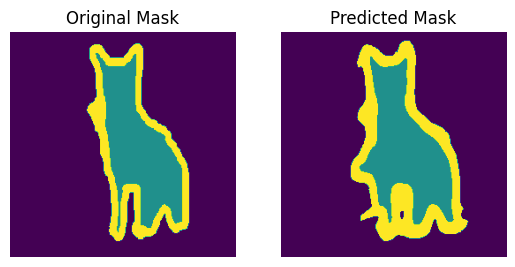

In [ ]:
image, mask = val_dataset.__getitem__(1)
image = image.unsqueeze(0).float().to(device)
mask = mask.squeeze(0).long().to(device)

with torch.no_grad():
    output = model(image)
    pred = output.argmax(dim=1).squeeze(0)

fig, axis = plt.subplots(1,3)

axis[0].imshow(mask.cpu())
axis[0].set_title("Original Mask")
axis[0].axis("off")

axis[1].imshow(pred.cpu())
axis[1].set_title("Predicted Mask")
axis[1].axis("off")

axis[2].imshow(image.cpu())
axis[2].set_title("original image")
axis[2].axis("off")

plt.show()